In [1]:
import math
import os
from collections import Counter
from functools import partial
from multiprocessing import Pool

import networkx as nx
import torch
import torch.nn as nn
import tqdm
from torch_geometric.data import Batch, Data

# from torch.utils.data import DataLoader, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

from Configures import mcts_args
from utils import PlotUtils

In [2]:
class MCTSNode:

    def __init__(
        self,
        coalition: list,
        data: Data,
        ori_graph: nx.Graph,
        c_puct: float = 10.0,
        W: float = 0,
        N: int = 0,
        P: float = 0,
    ):
        self.data = data
        self.coalition = coalition
        self.ori_graph = ori_graph
        self.c_puct = c_puct
        self.children = []
        self.W = W  # sum of node value
        self.N = N  # times of arrival
        self.P = P  # property score (reward)

    def Q(self):
        return self.W / self.N if self.N > 0 else 0

    def U(self, n):
        return self.c_puct * self.P * math.sqrt(n) / (1 + self.N)

In [3]:
def mcts_rollout(tree_node, state_map, data, graph, score_func):
    cur_graph_coalition = tree_node.coalition
    if len(cur_graph_coalition) <= mcts_args.min_atoms:
        return tree_node.P

    # Expand if this node has never been visited
    if len(tree_node.children) == 0:
        node_degree_list = list(graph.subgraph(cur_graph_coalition).degree)
        node_degree_list = sorted(
            node_degree_list, key=lambda x: x[1], reverse=mcts_args.high2low
        )
        all_nodes = [x[0] for x in node_degree_list]

        if len(all_nodes) < mcts_args.expand_atoms:
            expand_nodes = all_nodes
        else:
            expand_nodes = all_nodes[: mcts_args.expand_atoms]

        for each_node in expand_nodes:
            # for each node, pruning it and get the remaining sub-graph
            # here we check the resulting sub-graphs and only keep the largest one
            subgraph_coalition = [node for node in all_nodes if node != each_node]

            subgraphs = [
                graph.subgraph(c)
                for c in nx.connected_components(graph.subgraph(subgraph_coalition))
            ]
            main_sub = subgraphs[0]
            for sub in subgraphs:
                if sub.number_of_nodes() > main_sub.number_of_nodes():
                    main_sub = sub

            new_graph_coalition = sorted(list(main_sub.nodes()))

            # check the state map and merge the same sub-graph
            Find_same = False
            for old_graph_node in state_map.values():
                if Counter(old_graph_node.coalition) == Counter(new_graph_coalition):
                    new_node = old_graph_node
                    Find_same = True

            if Find_same == False:
                new_node = MCTSNode(new_graph_coalition, data=data, ori_graph=graph)
                state_map[str(new_graph_coalition)] = new_node

            Find_same_child = False
            for cur_child in tree_node.children:
                if Counter(cur_child.coalition) == Counter(new_graph_coalition):
                    Find_same_child = True

            if Find_same_child == False:
                tree_node.children.append(new_node)

        scores = compute_scores(score_func, tree_node.children)
        for child, score in zip(tree_node.children, scores):
            child.P = score

    sum_count = sum([c.N for c in tree_node.children])
    selected_node = max(tree_node.children, key=lambda x: x.Q() + x.U(sum_count))
    v = mcts_rollout(selected_node, state_map, data, graph, score_func)
    selected_node.W += v
    selected_node.N += 1
    return v


def mcts(data, gnnNet, prototype):
    data = Data(x=data.x, edge_index=data.edge_index)
    graph = to_networkx(data, to_undirected=True)
    data = Batch.from_data_list([data])
    num_nodes = graph.number_of_nodes()
    root_coalition = sorted([i for i in range(num_nodes)])
    root = MCTSNode(root_coalition, data=data, ori_graph=graph)
    state_map = {str(root.coalition): root}
    score_func = partial(gnn_prot_score, data=data, gnnNet=gnnNet, prototype=prototype)
    for rollout_id in range(mcts_args.rollout):
        mcts_rollout(root, state_map, data, graph, score_func)

    explanations = [node for _, node in state_map.items()]
    explanations = sorted(explanations, key=lambda x: x.P, reverse=True)
    explanations = sorted(explanations, key=lambda x: len(x.coalition))

    result_node = explanations[0]
    for result_idx in range(len(explanations)):
        x = explanations[result_idx]
        if len(x.coalition) <= mcts_args.max_atoms and x.P > result_node.P:
            result_node = x

    # compute the projected prototype to return
    mask = torch.zeros(data.num_nodes).type(torch.float32)
    mask[result_node.coalition] = 1.0
    ret_x = data.x * mask.unsqueeze(1)
    ret_edge_index = data.edge_index
    mask_data = Data(x=ret_x, edge_index=ret_edge_index)
    mask_data = Batch.from_data_list([mask_data])
    _, _, _, emb, _ = gnnNet(mask_data, protgnn_plus=False)
    return result_node.coalition, result_node.P, emb


def compute_scores(score_func, children):
    results = []
    for child in children:
        if child.P == 0:
            score = score_func(child.coalition)
        else:
            score = child.P
        results.append(score)
    return results


def gnn_prot_score(coalition, data, gnnNet, prototype):
    """the similarity value of subgraph with selected nodes"""
    epsilon = 1e-4
    mask = torch.zeros(data.num_nodes).type(torch.float32)
    mask[coalition] = 1.0
    ret_x = data.x * mask.unsqueeze(1)
    ret_edge_index = data.edge_index
    # row, col = data.edge_index
    # edge_mask = (mask[row] == 1) & (mask[col] == 1)
    # ret_edge_index = data.edge_index[:, edge_mask]

    mask_data = Data(x=ret_x, edge_index=ret_edge_index)
    mask_data = Batch.from_data_list([mask_data])
    _, _, _, emb, _ = gnnNet(mask_data, protgnn_plus=False)
    distance = torch.norm(emb - prototype) ** 2
    similarity = torch.log((distance + 1) / (distance + epsilon))
    return similarity.item()

In [4]:
import numpy as np

from Configures import data_args, model_args, train_args
from load_dataset import get_dataloader, get_dataset
from models import GnnNets, GnnNets_NC

print("start loading data====================")
dataset = get_dataset(data_args.dataset_dir, data_args.dataset_name)
input_dim = dataset.num_node_features
output_dim = int(dataset.num_classes)
dataloader = get_dataloader(
    dataset, train_args.batch_size, data_split_ratio=data_args.data_split_ratio
)
data_indices = dataloader["train"].dataset.indices
print("start training model==================")
gnnNets = GnnNets(input_dim, output_dim, model_args)
prototype_shape = (output_dim * model_args.num_prototypes_per_class, 128)
prototype_vectors = nn.Parameter(torch.rand(prototype_shape), requires_grad=False)
checkpoint = torch.load("./checkpoint/synthetic/gin_best.pth", weights_only=False)
gnnNets.update_state_dict(checkpoint["net"])
gnnNets
gnnNets.eval()

save_dir = os.path.join(
    "./new_results", f"{mcts_args.dataset_name}_" f"{model_args.model_name}_"
)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
plotutils = PlotUtils(dataset_name=data_args.dataset_name)

batch_indices = np.random.choice(data_indices, 1, replace=False)

start loading data====================
my_data/processed/data.pt
start training model==================


/opt/homebrew/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(f) != _repr(sel

In [5]:
import matplotlib.pyplot as plt


def plot_graph(G, title=None):
    nx.draw(
        to_networkx(G, to_undirected=True),
        with_labels=False,
        node_color="#3b8bc2",
        node_size=500,
        edge_color="k",
        linewidths=2,
        font_size=15,
    )
    if title:
        plt.title(title)
    plt.show()

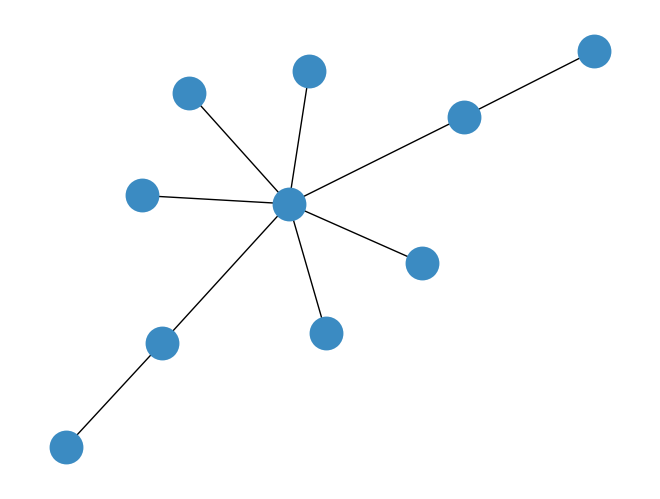

7 [0, 2, 3, 7, 9]
Saved prototype subgraph for graph 309 to ./new_results/synthetic_gin_/prototype_graph_309.pt


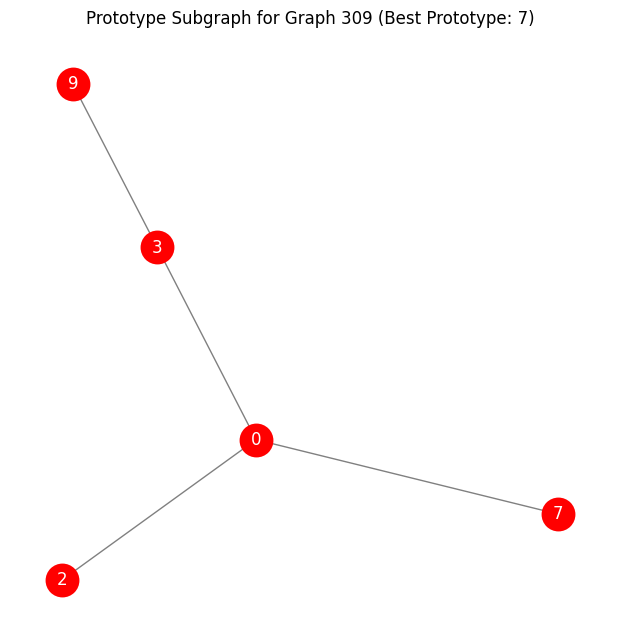

In [19]:
def find_best_prototype(data, gnnNet, prototype_vectors, num_prototypes):
    """
    Find the best prototype for the given graph data.
    This runs MCTS for each prototype and returns the one with the highest similarity score.
    """
    best_prototype_index = -1
    best_coalition = None
    best_similarity = -float("inf")
    best_prototype_embedding = None

    for prototype_index in range(num_prototypes):
        coalition, similarity, prototype_embedding = mcts(
            data, gnnNet, prototype_vectors[prototype_index]
        )

        # graph = to_networkx(data, to_undirected=True)
        # plotutils.plot(
        #     graph,
        #     coalition,
        #     x=data.x,
        #     figname=os.path.join(save_dir, f"example_{prototype_index}.png"),
        # )

        if similarity > best_similarity:
            best_similarity = similarity
            best_prototype_index = prototype_index
            best_coalition = coalition
            best_prototype_embedding = prototype_embedding

    return best_prototype_index, best_coalition, best_prototype_embedding


import matplotlib.pyplot as plt


def save_prototype_subgraph(data, gnnNet, prototype_vectors, save_dir, graph_index):
    best_prototype_index, best_coalition, _ = find_best_prototype(
        data, gnnNet, prototype_vectors, prototype_vectors.size(0)
    )

    print(best_prototype_index, best_coalition)

    graph = to_networkx(data, to_undirected=True)

    prototype_subgraph = graph.subgraph(best_coalition)

    prototype_data = {
        "nodes": best_coalition,
        "original_features": data.x[best_coalition].cpu(),
        "edges": list(prototype_subgraph.edges),
        "best_prototype_index": best_prototype_index,
    }

    save_path = os.path.join(save_dir, f"prototype_graph_{graph_index}.pt")
    torch.save(prototype_data, save_path)
    print(f"Saved prototype subgraph for graph {graph_index} to {save_path}")

    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(prototype_subgraph)

    nx.draw(
        prototype_subgraph,
        pos,
        with_labels=True,
        node_color="red",
        node_size=500,
        font_size=12,
        font_color="white",
        edge_color="gray",
        linewidths=2,
    )

    plt.title(
        f"Prototype Subgraph for Graph {graph_index} (Best Prototype: {best_prototype_index})"
    )
    plt.show()


graph_index = 309
data = dataset[graph_index]

plot_graph(data)
save_prototype_subgraph(data, gnnNets, prototype_vectors, save_dir, graph_index)

In [23]:
data_indices = dataloader["test"].dataset.indices
print(len(data_indices))

36
